# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import numpy as np
import pickle
import itertools
import math


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# b. MNIST Data Loader

In [4]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 256
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. DDPM**


# a. Building Blocks

In [6]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
          x1 = self.conv1(x)
          x2 = self.conv2(x1)
          if self.same_channels:
              out = x + x2
          else:
              out = x1 + x2
          return out / 1.414


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1+ temb1, down2)
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

# b. DDPM Schedules

In [59]:
def ddpm_schedules(beta1, beta2, T):
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    alpha_t = 0.0
    oneover_sqrta = 0.0
    sqrt_beta_t = 0.0
    alphabar_t= 0.0
    sqrtab = 0.0
    sqrtmab = 0.0
    mab_over_sqrtmab_inv  = 0.0
    ##################
    ### Problem 1 (a): Implement ddpm_schedules()
    ##################
    ##################
    
    beta_t=torch.Tensor(np.array([0]+[beta1+float(t)*(beta2-beta1)/float(T-1) for t in range(0,T)])).unsqueeze(0).to(device)
    alpha_t=1.0-beta_t
    oneover_sqrta=1.0/torch.sqrt(alpha_t)
    sqrt_beta_t=torch.sqrt(beta_t)
    alphabar_t=torch.cumprod(alpha_t,dim=-1)
    sqrtab=torch.sqrt(alphabar_t)
    sqrtmab=torch.sqrt(1.0-alphabar_t)
    mab_over_sqrtmab_inv=(1.0-alpha_t)/sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

# c. DDPM Main Module



In [62]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        b=c.shape[0]
        t=torch.randint(0, self.n_T, size=(b,1),device=self.device)
        sqrtab=self.sqrtab.broadcast_to((b,self.sqrtab.shape[-1]))
        sqrtab=torch.gather(sqrtab, dim=-1, index=t).unsqueeze(-1).unsqueeze(-1)
        
        mab=self.sqrtmab.broadcast_to((b,self.sqrtmab.shape[-1]))
        mab=torch.gather(mab, dim=-1, index=t).unsqueeze(-1).unsqueeze(-1)
        
        eps=torch.randn_like(x)
        xt=sqrtab*x+mab*eps
        context_mask = torch.zeros_like(c).to(self.device)
        
        eps_theta=self.nn_model(xt,c,t.float(),context_mask)
        
        return self.loss_mse(eps_theta,eps)

    def sample(self, n_sample, size, device, guide_w=0.0):
        x_i = torch.randn(n_sample, *size).to(device)
        c_i = torch.arange(0, 10).to(device)
        c_i = c_i.repeat(n_sample // c_i.shape[0])

        context_mask = torch.zeros_like(c_i).to(device)

        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1.0  # second half context-free

        for i in range(self.n_T, 0, -1):
            print(f'Sampling timestep {i}', end='\r')
            
            time=torch.ones(size=(x_i.shape[0],),device=device)*i
            eps=self.nn_model(x_i,c_i[:n_sample],time,context_mask[:n_sample])
            oneover_sqrta=self.oneover_sqrta[...,i].item()
            coeff=self.mab_over_sqrtmab[...,i].item()
            var=self.sqrt_beta_t[...,i]*self.sqrtmab[...,i-1]/self.sqrtmab[...,i]
            var=var.item()
            if i>1:
                z=torch.randn_like(x_i)
            else:
                z=torch.zeros_like(x_i)
            x_i=oneover_sqrta*(x_i-coeff*eps)+var*z
        return x_i


# c. Training Function

In [65]:
def train_main_loop(ddpm, optim, dataloader, lr,
                    ws_test, n_epoch, batch_size):
    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lr*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        # train
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        # eval
        ddpm.eval()
        with torch.no_grad():
            n_sample = 20
            for w_i, w in enumerate(ws_test):
                x_gen = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)

            fig, ax = plt.subplots(5, 4, figsize=(6, 6))
            for i, j in itertools.product(range(5), range(4)):
                ax[i,j].get_xaxis().set_visible(False)
                ax[i,j].get_yaxis().set_visible(False)

            for k in range(n_sample):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(x_gen[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            plt.show()

        if ep == n_epoch - 1:
          plt.savefig('final_generated_samples.png', bbox_inches='tight')


# e. Training


epoch 0


  0%|          | 0/235 [00:00<?, ?it/s]

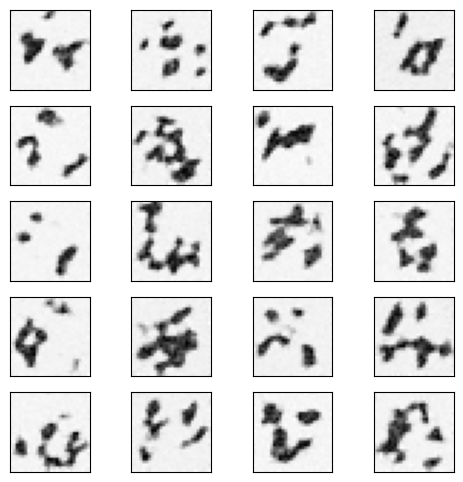

epoch 1


  0%|          | 0/235 [00:00<?, ?it/s]

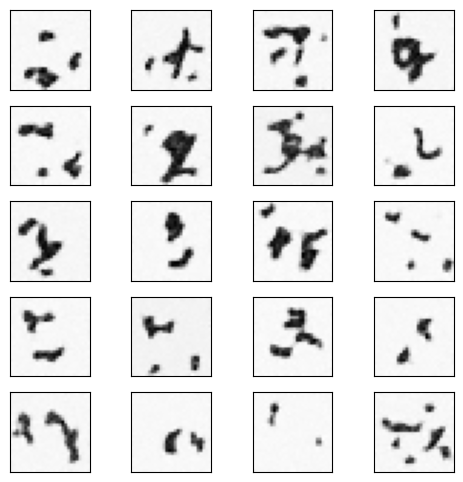

epoch 2


  0%|          | 0/235 [00:00<?, ?it/s]

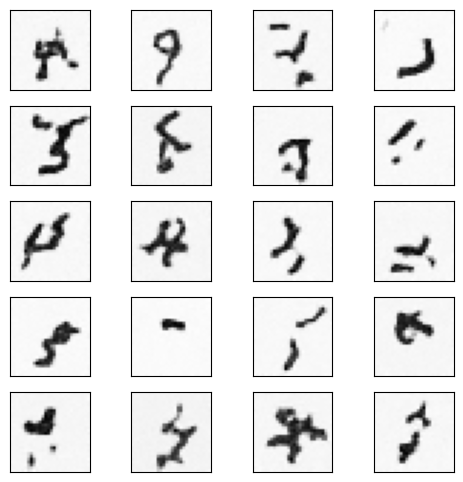

epoch 3


  0%|          | 0/235 [00:00<?, ?it/s]

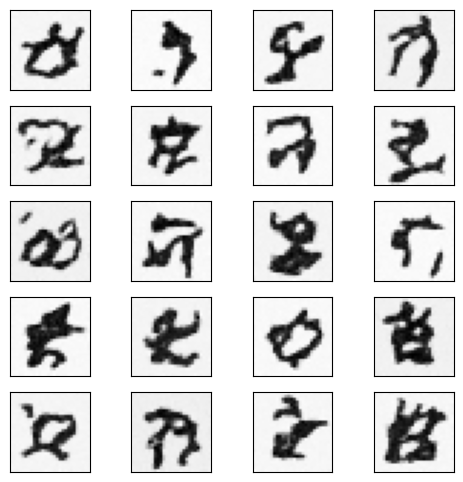

epoch 4


  0%|          | 0/235 [00:00<?, ?it/s]

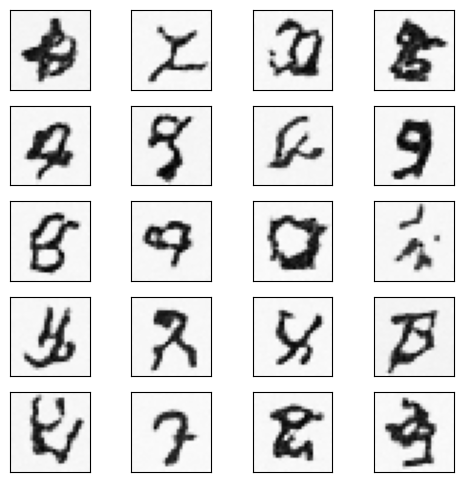

epoch 5


  0%|          | 0/235 [00:00<?, ?it/s]

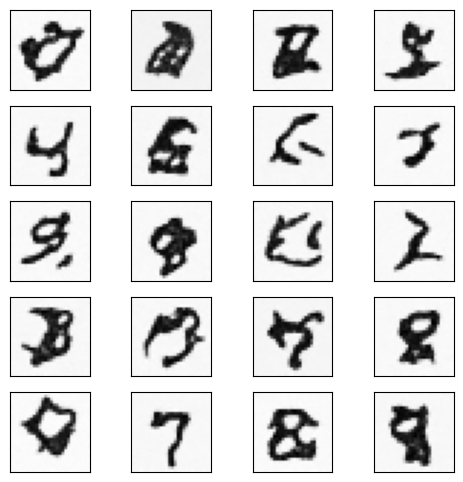

epoch 6


  0%|          | 0/235 [00:00<?, ?it/s]

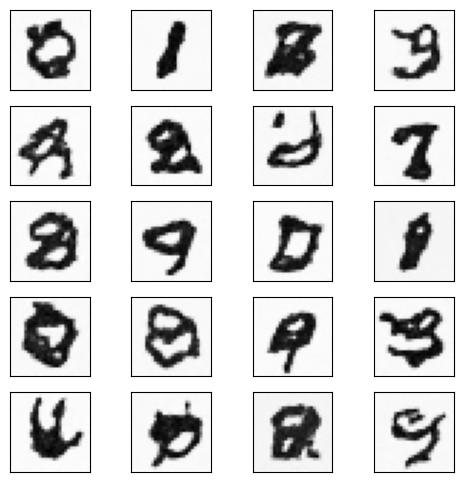

epoch 7


  0%|          | 0/235 [00:00<?, ?it/s]

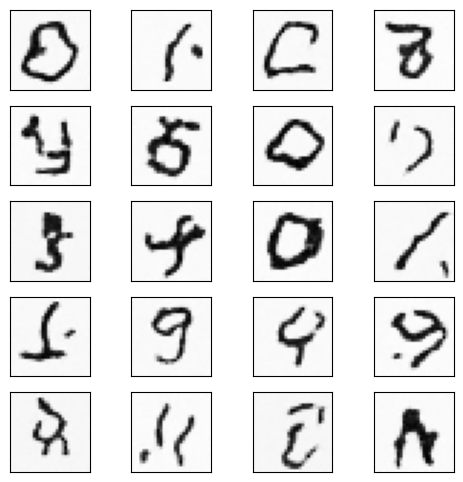

epoch 8


  0%|          | 0/235 [00:00<?, ?it/s]

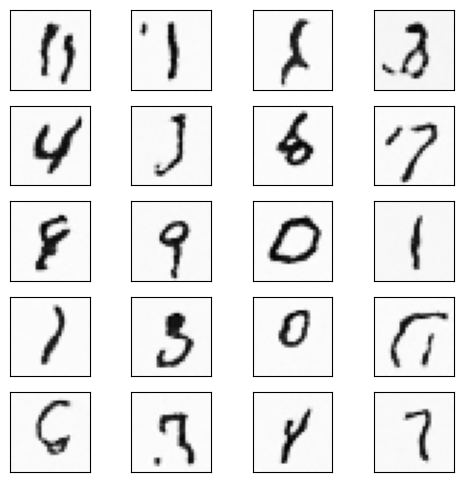

epoch 9


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 10


  0%|          | 0/235 [00:00<?, ?it/s]

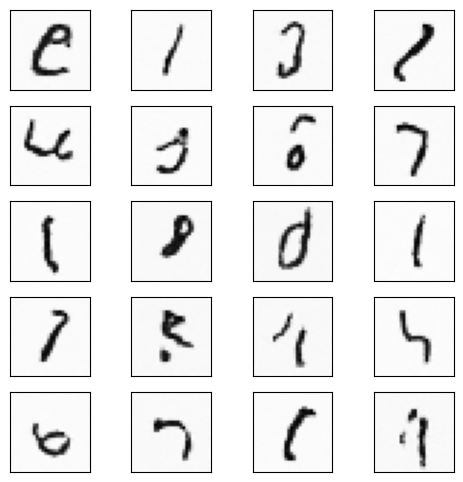

epoch 11


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 12


  0%|          | 0/235 [00:00<?, ?it/s]

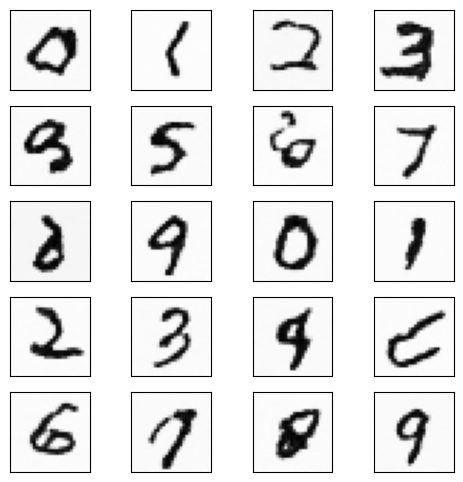

epoch 13


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 14


  0%|          | 0/235 [00:00<?, ?it/s]

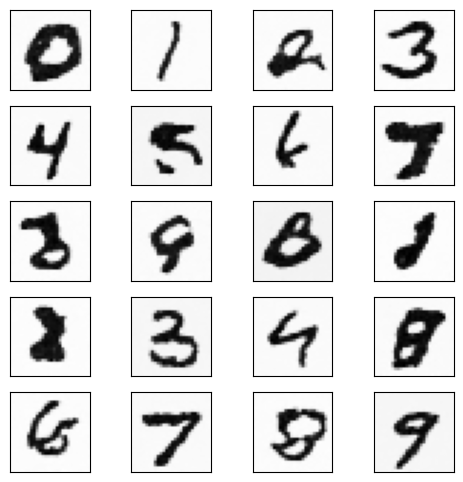

epoch 15


  0%|          | 0/235 [00:00<?, ?it/s]

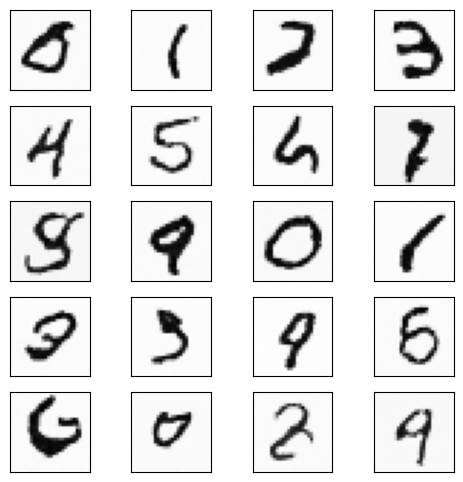

epoch 16


  0%|          | 0/235 [00:00<?, ?it/s]

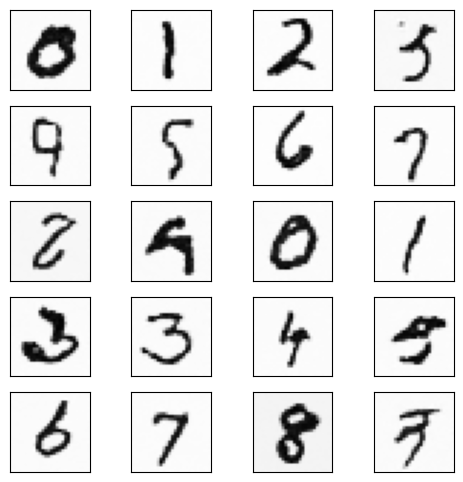

epoch 17


  0%|          | 0/235 [00:00<?, ?it/s]

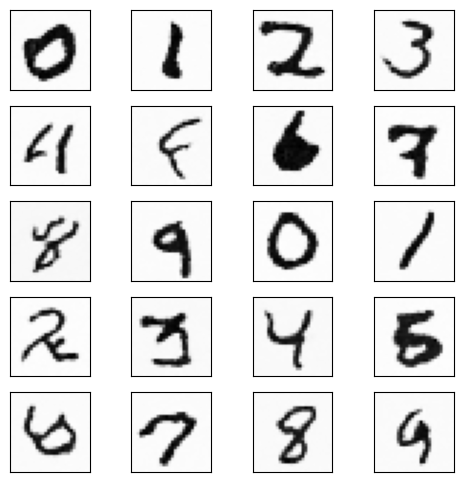

epoch 18


  0%|          | 0/235 [00:00<?, ?it/s]

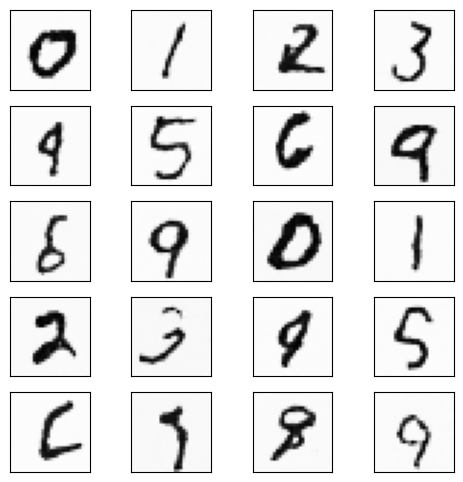

epoch 19


  0%|          | 0/235 [00:00<?, ?it/s]

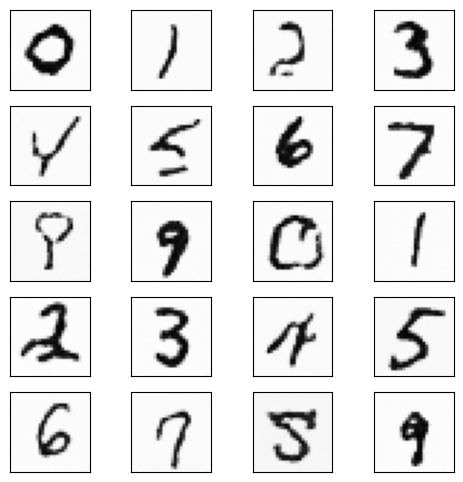

<Figure size 640x480 with 0 Axes>

In [72]:
# hardcoding these here
n_epoch = 20
n_T = 400
n_feat = 128
lr = 1e-4
ws_test = [0.0, 0.5, 2.0]

ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
train_main_loop(ddpm, optim, train_loader, lr, ws_test, n_epoch, batch_size)


# **2. Ablation Study**

epoch 0


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 1


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 2


  0%|          | 0/235 [00:00<?, ?it/s]

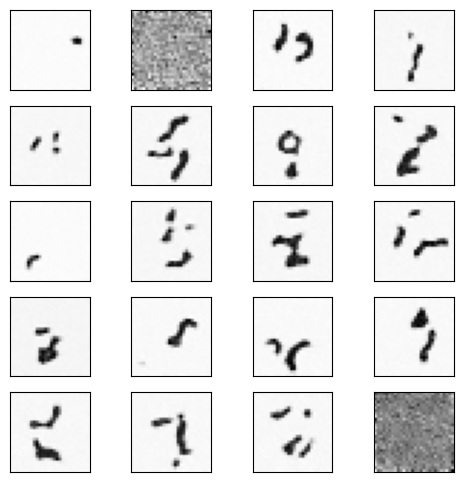

epoch 3


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 4


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 5


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 6


  0%|          | 0/235 [00:00<?, ?it/s]

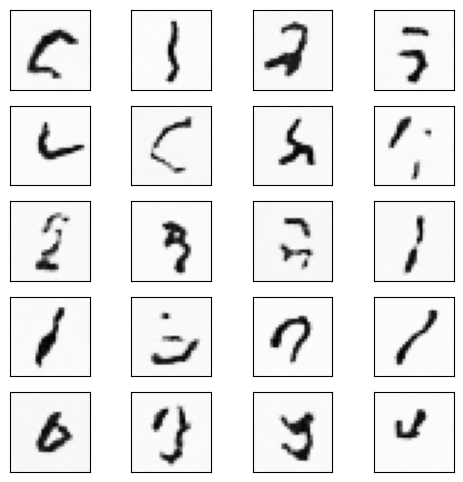

epoch 7


  0%|          | 0/235 [00:00<?, ?it/s]

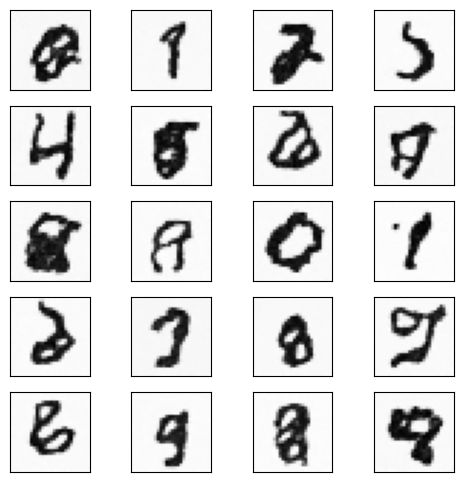

epoch 8


  0%|          | 0/235 [00:00<?, ?it/s]

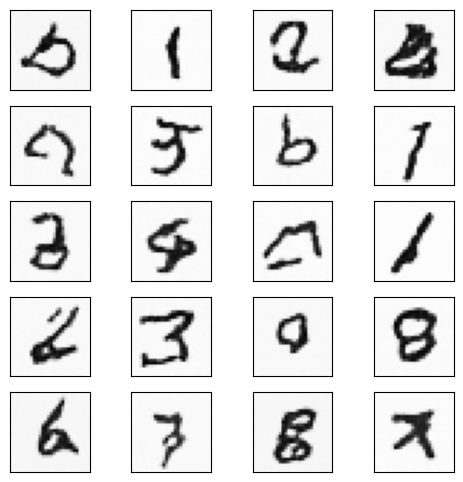

epoch 9


  0%|          | 0/235 [00:00<?, ?it/s]

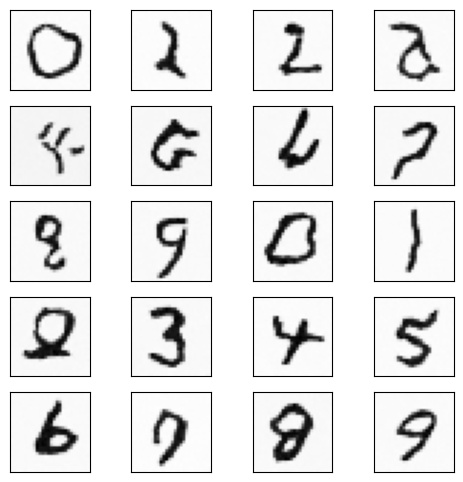

epoch 10


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 11


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 12


  0%|          | 0/235 [00:00<?, ?it/s]

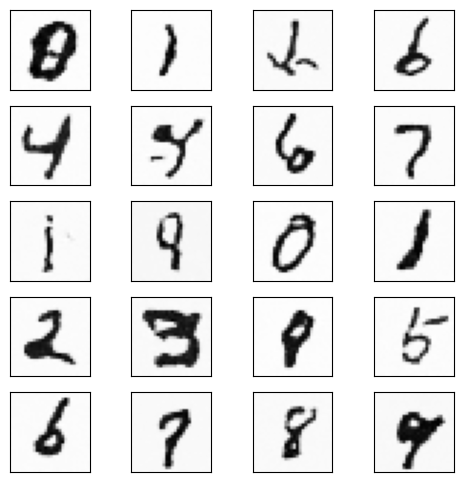

epoch 13


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 14


  0%|          | 0/235 [00:00<?, ?it/s]

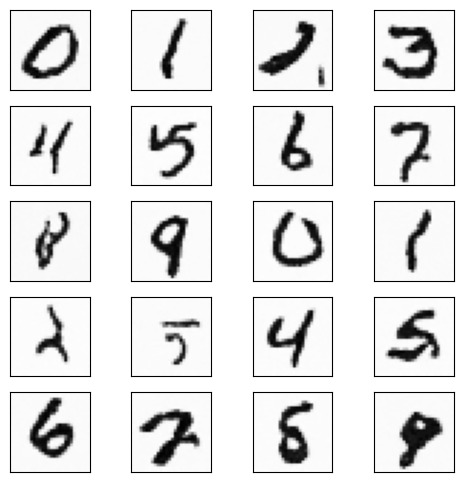

epoch 15


  0%|          | 0/235 [00:00<?, ?it/s]

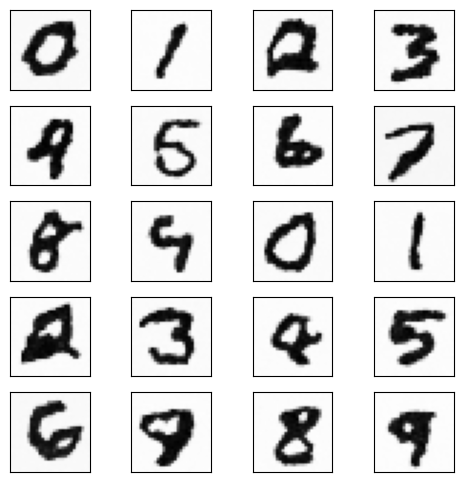

epoch 16


  0%|          | 0/235 [00:00<?, ?it/s]

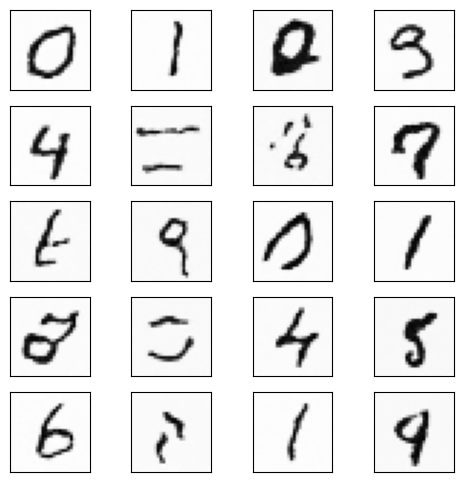

epoch 17


  0%|          | 0/235 [00:00<?, ?it/s]

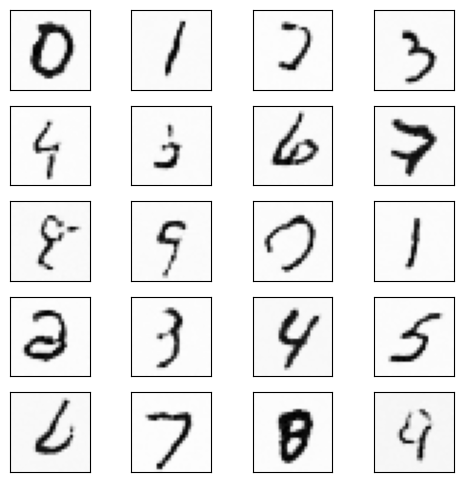

epoch 18


  0%|          | 0/235 [00:00<?, ?it/s]

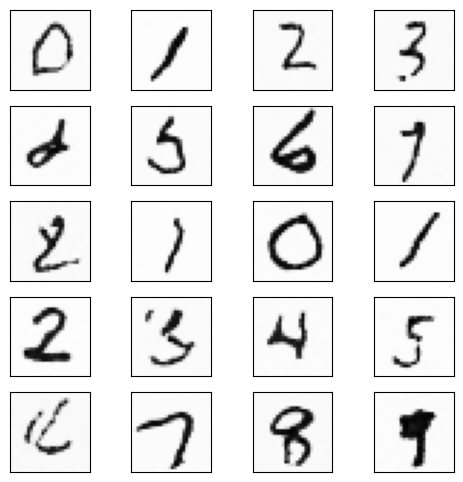

epoch 19


  0%|          | 0/235 [00:00<?, ?it/s]

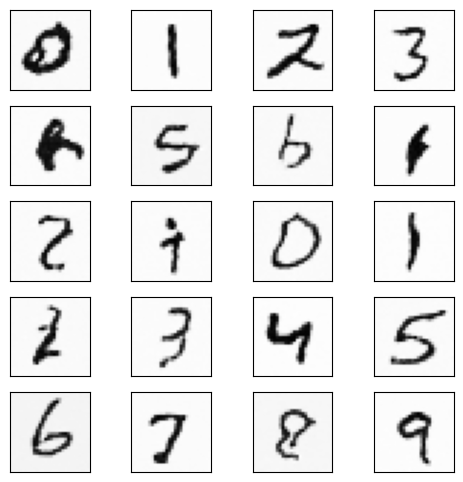

<Figure size 640x480 with 0 Axes>

In [74]:
##################
### Problem 2: Ablation Study
##################
n_epoch = 20
n_T = 500
n_feat = 128
lr = 1e-4
ws_test = [0.0, 0.5, 2.0]

ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
train_main_loop(ddpm, optim, train_loader, lr, ws_test, n_epoch, batch_size)

# **3. Continuous-time Stochastic Process**

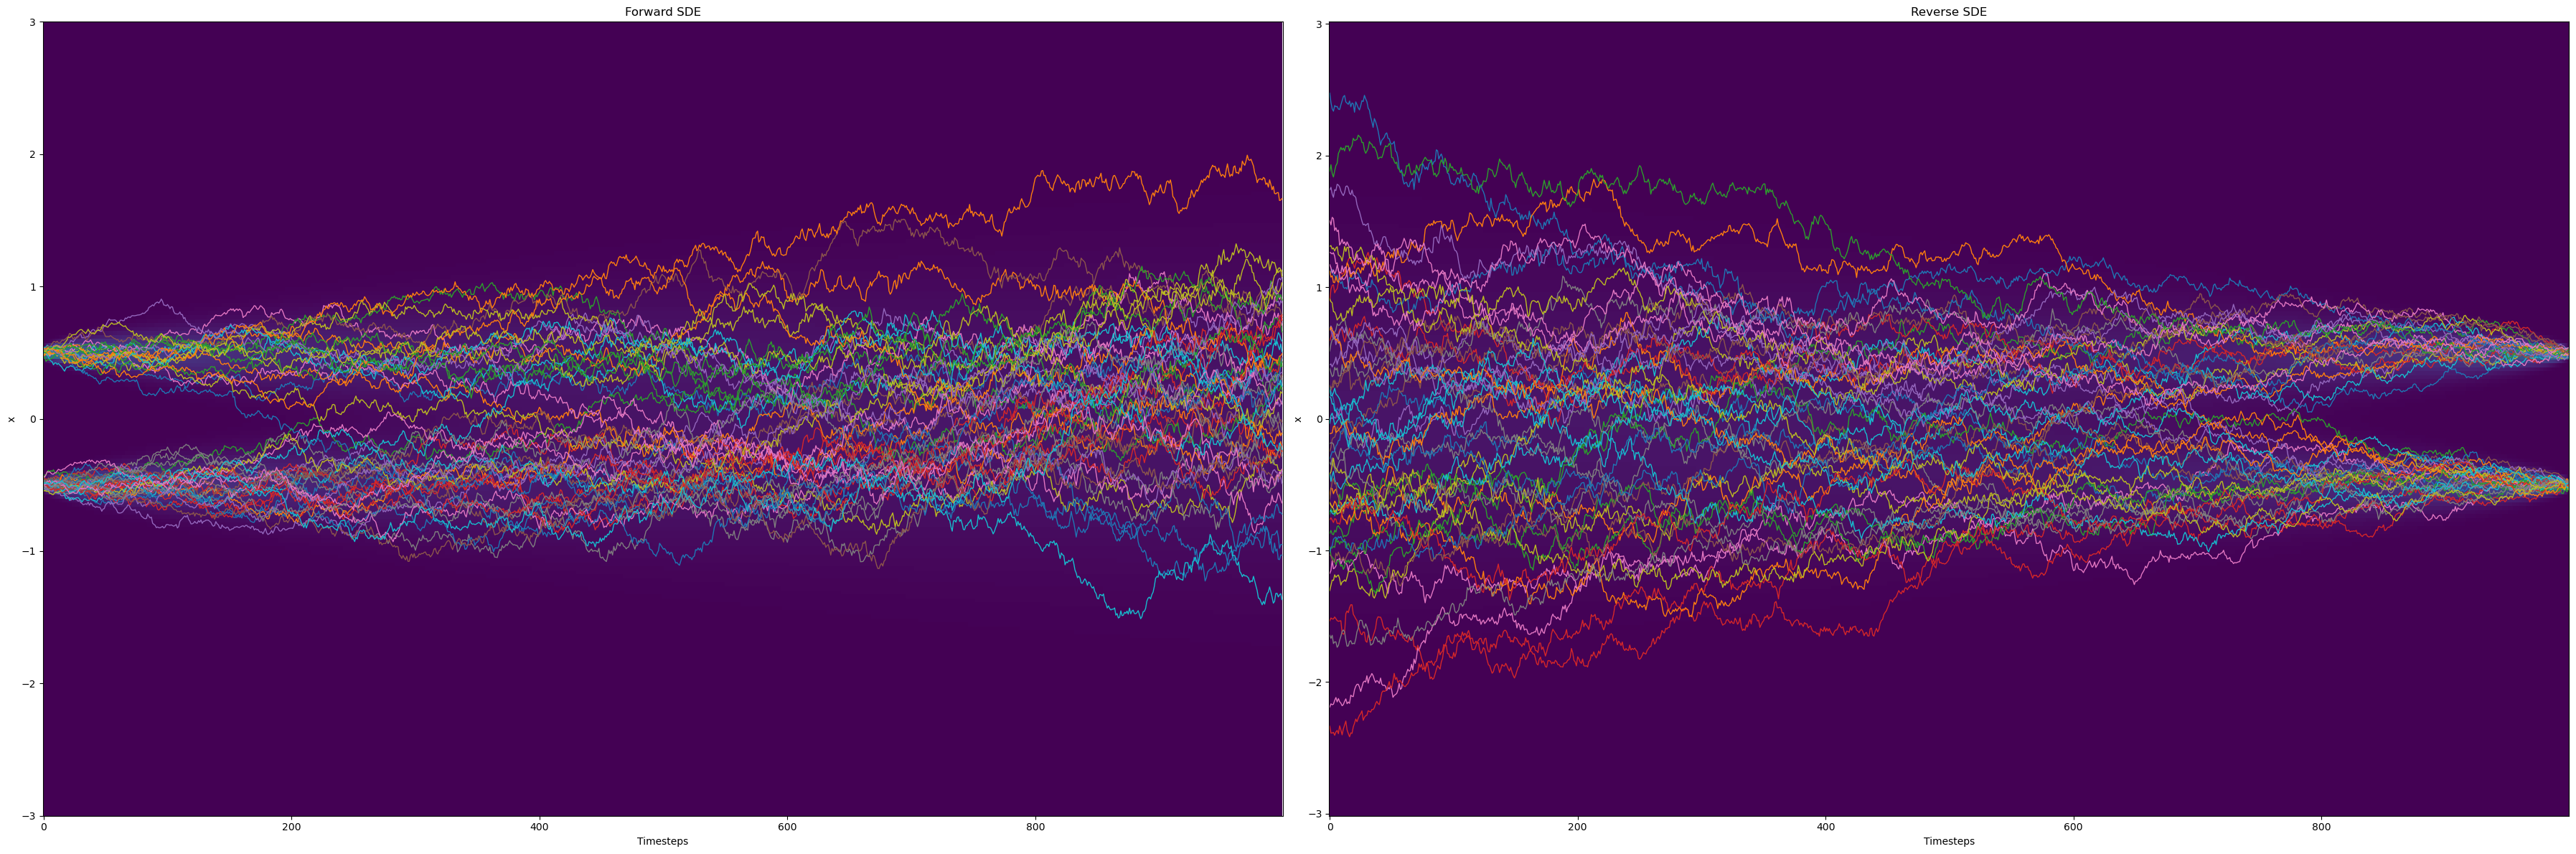

In [170]:
timesteps = 1000
beta1 = 0.1
beta2 = 1
dt = 1.0 / timesteps
means = np.array([0.5, -0.5])
stds = np.array([0.02, 0.02])
weights = np.array([0.5, 0.5])
weights /= np.sum(weights)
n_samples = 50
x_min = -3
x_max = 3
x_grid = np.linspace(x_min, x_max, num=200)

def get_beta_t(t):
    ratio = float(t) / timesteps
    return ratio * beta2 + (1 - ratio) * beta1

def f(x, t):
    beta_t = get_beta_t(t)
    return -0.5 * beta_t * x

def g(t):
    beta_t = get_beta_t(t)
    return np.sqrt(beta_t)

def gaussian_pdf(x, mean, std):
    return (1.0 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

def mixture_pdf(x):
    pdf = np.zeros_like(x)
    for i in range(len(means)):
        pdf += weights[i] * gaussian_pdf(x, means[i], stds[i])
    return pdf

def sample_mixture_gaussian(n_samples):
    components = np.random.choice(len(means), size=n_samples, p=weights / np.sum(weights))
    samples = np.random.normal(loc=means[components], scale=stds[components])
    return samples

def p_xt(x_t, t):
    p_xt_val = np.zeros_like(x_t)
    ##################
    ### Problem 3(a): p(x(t))
    ##################
    ##################
    t=float(t)/timesteps
    mean=means[0]*np.exp(-0.25*t*t*(beta2-beta1)-0.5*t*beta1)
    var=stds[0]*stds[0]*np.exp(-0.5*t*t*(beta2-beta1)-t*beta1)+1-np.exp(-0.5*t*t*(beta2-beta1)-t*beta1)
    std=np.sqrt(var)
    u1=weights[0]*gaussian_pdf(x_t, mean, std)

    mean=means[1]*np.exp(-0.25*t*t*(beta2-beta1)-0.5*t*beta1)
    var=stds[1]*stds[1]*np.exp(-0.5*t*t*(beta2-beta1)-t*beta1)+1-np.exp(-0.5*t*t*(beta2-beta1)-t*beta1)
    std=np.sqrt(var)
    u2=weights[1]*gaussian_pdf(x_t, mean, std)
    p_xt_val=u1+u2
    return p_xt_val

def grad_log_p_xt(x_t, t):
    ##################
    ### Problem 3(b): \nabla_x(t) \log p(x(t))
    ##################
    ##################

    p_xt_val=p_xt(x_t, t)

    t=float(t)/timesteps
    mean=means[0]*np.exp(-0.25*t*t*(beta2-beta1)-0.5*t*beta1)
    var=stds[0]*stds[0]*np.exp(-0.5*t*t*(beta2-beta1)-t*beta1)+1-np.exp(-0.5*t*t*(beta2-beta1)-t*beta1)
    std=np.sqrt(var)
    u1=weights[0]*gaussian_pdf(x_t, mean, std)*(-1)*(x_t-mean)/var

    mean=means[1]*np.exp(-0.25*t*t*(beta2-beta1)-0.5*t*beta1)
    var=stds[1]*stds[1]*np.exp(-0.5*t*t*(beta2-beta1)-t*beta1)+1-np.exp(-0.5*t*t*(beta2-beta1)-t*beta1)
    std=np.sqrt(var)
    u2=weights[1]*gaussian_pdf(x_t, mean, std)*(-1)*(x_t-mean)/var
    grad=u1+u2
    return grad/p_xt_val

def forward_sde(timesteps, n_samples, dt):
    x = np.zeros((timesteps, n_samples))

    x_pdf = np.zeros((timesteps, x_grid.shape[0]))

    x0 = sample_mixture_gaussian(n_samples)
    x0_pdf = mixture_pdf(x_grid)
    x[0] = x0
    x_pdf[0] = x0_pdf

    for t in range(1, timesteps):
        noise = np.random.normal(0, 1, size=n_samples)
        x[t] = x[t-1] + f(x[t-1], t) * dt + g(t) * noise * np.sqrt(dt)
        x_pdf[t] = p_xt(x_grid, t)

    return x, x_pdf

def backward_sde(timesteps, n_samples, dt):
    x = np.zeros((timesteps, n_samples))
    xT = np.random.normal(0, 1, size=n_samples)
    x[-1] = xT

    for t in range(timesteps - 1, 0, -1):
        noise = np.random.normal(0, 1, size=n_samples)
        delta_x = (f(x[t], t) - g(t) ** 2 * grad_log_p_xt(x[t], t)) * dt + g(t) * noise * np.sqrt(dt)
        x[t-1] = x[t] - delta_x
        
    return x

forward_x, forward_x_pdf = forward_sde(timesteps, n_samples, dt)
backward_data = backward_sde(timesteps, n_samples, dt)

fig, axes = plt.subplots(1, 2, figsize=(36, 12))

for i in range(n_samples):
    axes[0].plot(forward_x[:, i], lw=1)

time = np.arange(timesteps)
X, Y = np.meshgrid(time, x_grid)
pcm = axes[0].pcolormesh(X, Y, forward_x_pdf.T,
                         cmap='viridis', shading='auto', vmin=0.0, vmax=forward_x_pdf.max())
axes[0].set_title('Forward SDE')
axes[0].set_xlabel('Timesteps')
axes[0].set_ylabel('x')
axes[0].set_ylim([x_min, x_max])

for i in range(n_samples):
    axes[1].plot(backward_data[::-1][:, i], lw=1)

X, Y = np.meshgrid(time, x_grid)
pcm = axes[1].pcolormesh(X, Y, forward_x_pdf[::-1].T,
                         cmap='viridis', shading='auto', vmin=0.0, vmax=forward_x_pdf.max())
axes[1].set_title('Reverse SDE')
axes[1].set_xlabel('Timesteps')
axes[1].set_ylabel('x')

plt.tight_layout()
plt.show()
